# NEW FUNC

In [135]:
import numpy as np
from scipy.optimize import fmin_cobyla
from matplotlib import pylab as plt

import optimizers
from importlib import reload

In [158]:
def f(x, args):
    summa = 0
    for a_i, b_i in zip(args['A'], args['b']):
        summa += args['sigma']**2*(1-np.exp(-(b_i - x @ a_i)**2/args['sigma']))
    
    return 1./args['n'] * summa

def gradient_true(x, args):
    summa = 0
    for a_i, b_i in zip(args['A'], args['b']):
        summa += np.exp(-(b_i - x @ a_i)**2/args['sigma'])*(b_i - x @ a_i)*a_i
    
    return 2./args['n'] * summa

def calculate(args, optimizer, R_0, label, title):
    
    w_sol, errors, times = optimizer.search()
    iterations = range(1, len(errors)+1)
    
    return iterations, errors / R_0, label, times, w_sol

def const_gamma(k, func, nabla_f, x_curr, args):
    return 0.001

def momentum_k(k, f, nabla_f, x_k, args):
    return k / (k + 1)

In [159]:
args = {}
args['d'] = 10
args['func'] = f
args['seed'] = 42

args['gamma'] = lambda k: 1 / np.sqrt(k + 1)
args['eps'] = 0.0
args['criterium'] = 'f(x_k) - f(x^*)'

args['n'] = 100
args['A'] = []
args['sigma'] = 1
'''
args['b'] = np.random.random_sample(args['n'])

for _ in range(args['n']):
    args['A'].append(10 * np.random.random_sample(args['d']))
'''

args['A'] = np.random.default_rng().multivariate_normal(np.zeros(args['d']),
np.identity(args['d']), 
args['n'])
args['b'] = args['A'] @ (np.random.random_sample(args['d']) * 2 - 1) \
+ (np.random.random_sample(args['n']) * 2 - 1)

args['oracle_counter'] = 0
args['oracle_calls'] = []

# Finding x_sol

In [163]:
reload(optimizers)

def const_gamma(k, func, nabla_f, x_curr, args):
    return args['c'] / (k + 3)

def fw_step(k, func, nabla_f, x_curr, args):
    return 2 / (k + 3)

def momentum_fw(k, f, nabla_f, x_k, args):
    return (k+1) / (k + 3)

args['momentum_k'] = momentum_fw
args['max_steps'] = 10**4
args['batch_size'] = 1
args['use_proj'] = False
args['criterium'] = 'nabla(f)(x_k)'
np.random.seed(args['seed'])
w_0 = np.random.random_sample(args['d'])
args['jaguar'] = False
args['use_proj'] = True
args['c'] = 5.

### l_1 ball ###
args['set'] = 'l1_ball'
w_0_l1 = w_0 / np.linalg.norm(w_0, ord=1)
w_true_sol_l1, err , _ = optimizers.GDOptimizer(f, gradient_true, 
                                                x_0 = w_0_l1,
                                                step = const_gamma, 
                                                args = args).search()
R_0_l1 = f(w_0_l1, args) - f(w_true_sol_l1, args)
args['use_proj'] = False

100%|██████████| 10000/10000 [00:05<00:00, 1810.65it/s]


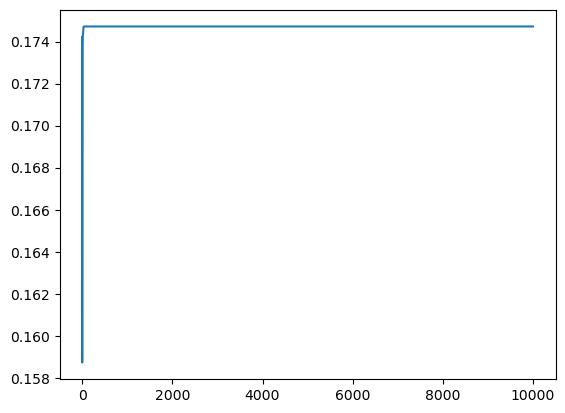

In [164]:
plt.plot(err)

# Different metods

## MBFW

In [143]:
reload(optimizers)
title = ''


args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['jaguar'] = True
args['prob'] = 1e-3
#####
args['grad_curr'] = np.zeros(args['d'])
######
iterations_mbfw = []
errors_mbfw = []
labels_mbfw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_opf_jaguar],
                          ['TPF', 'OPF']):
        args['set'] = Q
        '''
        if name == 'OPF' or Q == 'simplex':
            args['jaguar'] = True
        else:
            args['jaguar'] = False
        '''
        optimizer = optimizers.MBFWOptimizer(f, grad, x_0 = w_0, 
                                             step = fw_step, args = args)

        label = f'MBFW, {name}, {Q}'

        iterations, errors, _, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_mbfw.append(iterations)
        errors_mbfw.append(errors)
        labels_mbfw.append(label)

  0%|          | 0/10000 [00:00<?, ?it/s]

/var/folders/kd/mxk4216x0hb7hph3jhhp3tp80000gn/T/ipykernel_99306/642134061.py:20: RuntimeWarning: divide by zero encountered in divide
  return iterations, errors / R_0, label, times, w_sol



  0%|          | 0/10000 [00:00<?, ?it/s]


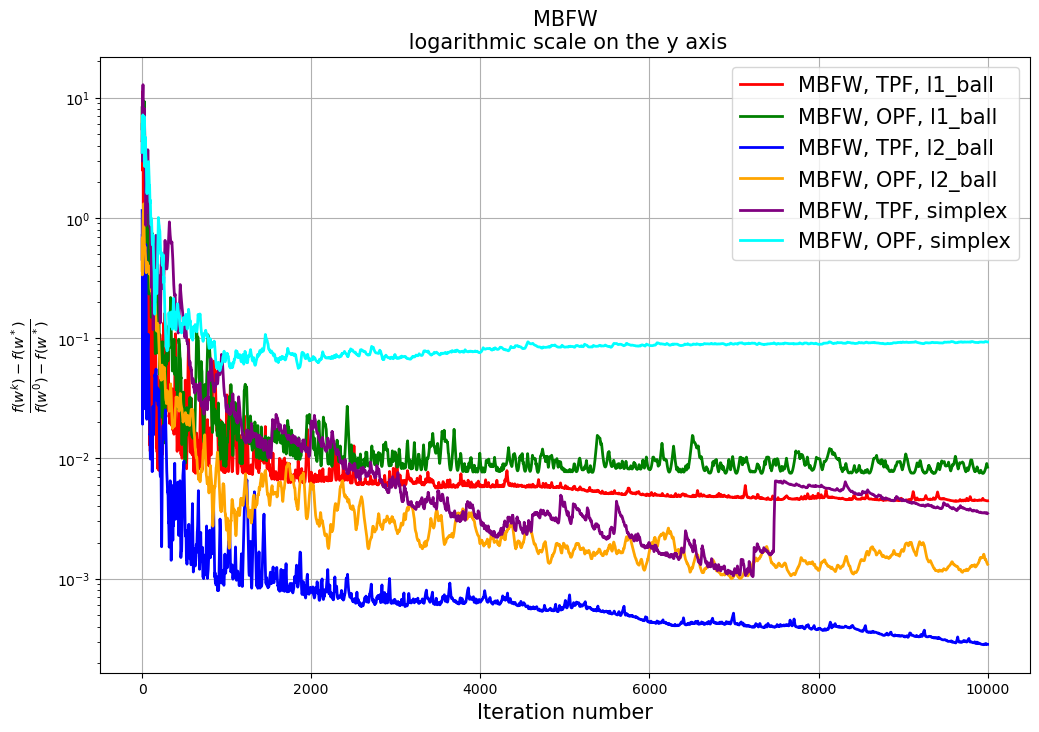

In [93]:
title = "MBFW"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_mbfw, errors_mbfw, y_label=y_label,
                     labels=labels_mbfw, title=title, markers=[None]*100)

## FW

In [95]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['jaguar'] = True
args['prob'] = 1e-3

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_fw = []
errors_fw = []
labels_fw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_opf_jaguar],
                          ['TPF', 'OPF']):
        args['set'] = Q
        '''
        if name == 'OPF' or Q == 'simplex':
            args['jaguar'] = True
        else:
            args['jaguar'] = False
        '''
        optimizer = optimizers.FWOptimizer(f, grad, x_0 = w_0, 
                                           step = fw_step, args = args)

        label = f'FW, {name}, {Q}'

        iterations, errors, _, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_fw.append(iterations)
        errors_fw.append(errors)
        labels_fw.append(label)

100%|██████████| 10000/10000 [00:00<00:00, 36771.21it/s]


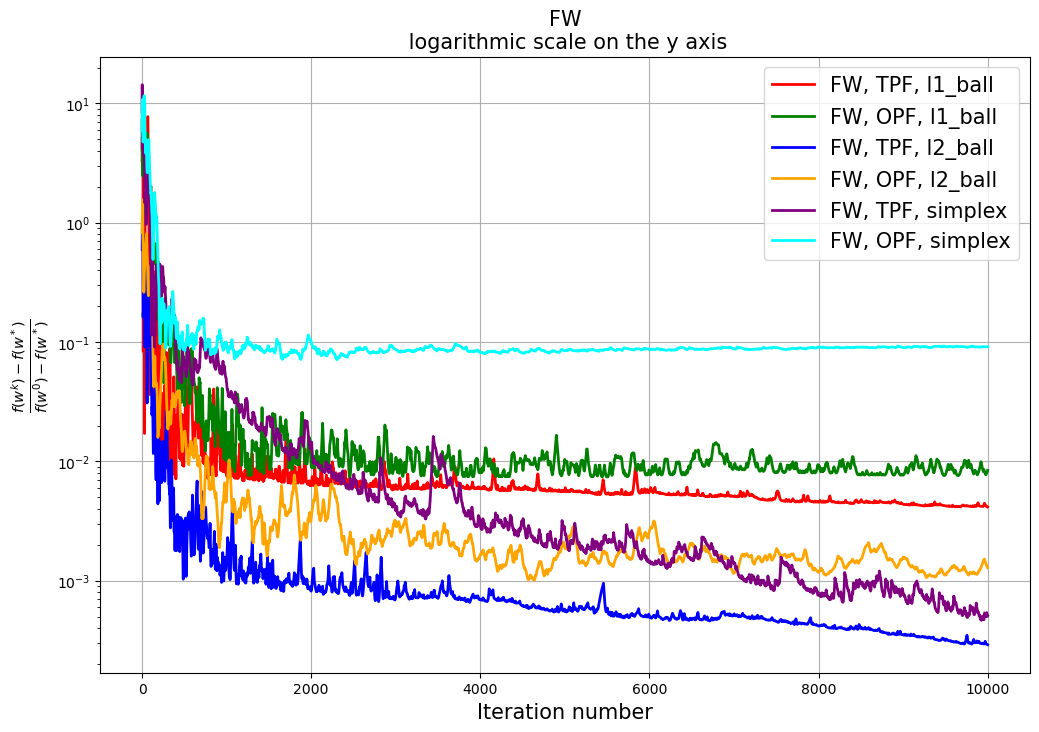

In [96]:
title = "FW"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fw, errors_fw, y_label=y_label,
                         labels=labels_fw, title=title, markers=[None]*100)

## Projection

In [97]:
def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (args['c'] * args['L'])

In [176]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 3
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = True
args['gamma'] = lambda k: 1e-1
args['jaguar'] = True
args['prob'] = 1e-3

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_proj = []
errors_proj = []
labels_proj = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_opf_jaguar],
                          ['TPF', 'OPF']):
        args['set'] = Q
        
        if name == 'TPF':
            args['c'] = 70.
        else:
            args['c'] = 100.
        optimizer = optimizers.GDOptimizer(f, grad, x_0 = w_0, 
                                           step = const_gamma, args = args)

        label = f'Projection, {name}, {Q}'

        iterations, errors, _, _, w = calculate(args, optimizer, R_0, label, title)
        print(Q, name, f(w, args), sum(w), f(w_sol, args))
        iterations_proj.append(iterations)
        errors_proj.append(errors)
        labels_proj.append(label)

100%|██████████| 1000/1000 [00:00<00:00, 19042.25it/s]
l1_ball TPF [-0.08445351] 0.13713191886848852 [-0.15776222]
100%|██████████| 1000/1000 [00:00<00:00, 24767.81it/s]
l1_ball OPF [2.53039556] 0.3696982478067984 [-0.15776222]
100%|██████████| 1000/1000 [00:00<00:00, 17774.58it/s]
l2_ball TPF [-0.10706711] 0.171442074744807 [-0.17453938]
100%|██████████| 1000/1000 [00:00<00:00, 21097.58it/s]
l2_ball OPF [101.86464142] 0.33168650762494833 [-0.17453938]
100%|██████████| 1000/1000 [00:00<00:00, 18888.92it/s]
simplex TPF [3.1812873] 1.0 [3.18128715]
100%|██████████| 1000/1000 [00:00<00:00, 24088.86it/s]
simplex OPF [11.82839103] 0.9999999999999998 [3.18128715]


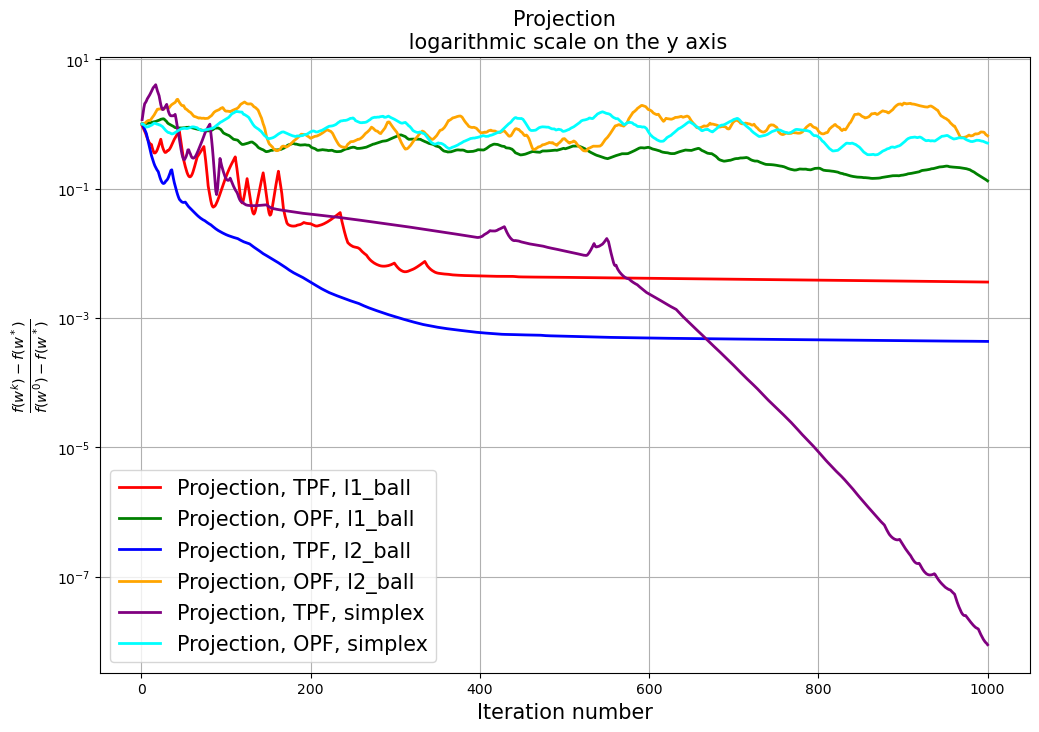

In [177]:
title = "Projection"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_proj, errors_proj, y_label=y_label,
                         labels=labels_proj, title=title, markers=[None]*100)

## FZCGS

In [133]:
def const_gamma(k, func, nabla_f, x_curr, args):
    return 1. / (args['c'] * args['L'])
def eta(k, func, nabla_f, x_curr, args):
    return args['eta_0']/(k+1)

In [137]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['gamma'] = lambda k: 1e-1
args['eta'] = eta
args['jaguar'] = True
args['prob'] = 1e-3
#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_fzcgs = []
errors_fzcgs = []
labels_fzcgs = []

for Q, w_0, R_0, w_sol in zip(['l1_ball'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_opf_jaguar],
                          ['TPF', 'OPF']):
        args['set'] = Q
        if name == 'TPF':
            args['c'] = 30.
            args['eta_0'] = 100.
        else:
            args['c'] = 30.
            args['eta_0'] = 50.
        optimizer = optimizers.FZCGSOptimizer(f, grad, x_0 = w_0, 
                                              step = const_gamma, args = args)

        label = f'FZCGS, {name}, {Q}'

        iterations, errors, _, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_fzcgs.append(iterations)
        errors_fzcgs.append(errors)
        labels_fzcgs.append(label)

  3%|▎         | 282/10000 [00:06<03:31, 45.89it/s]  


KeyboardInterrupt: 

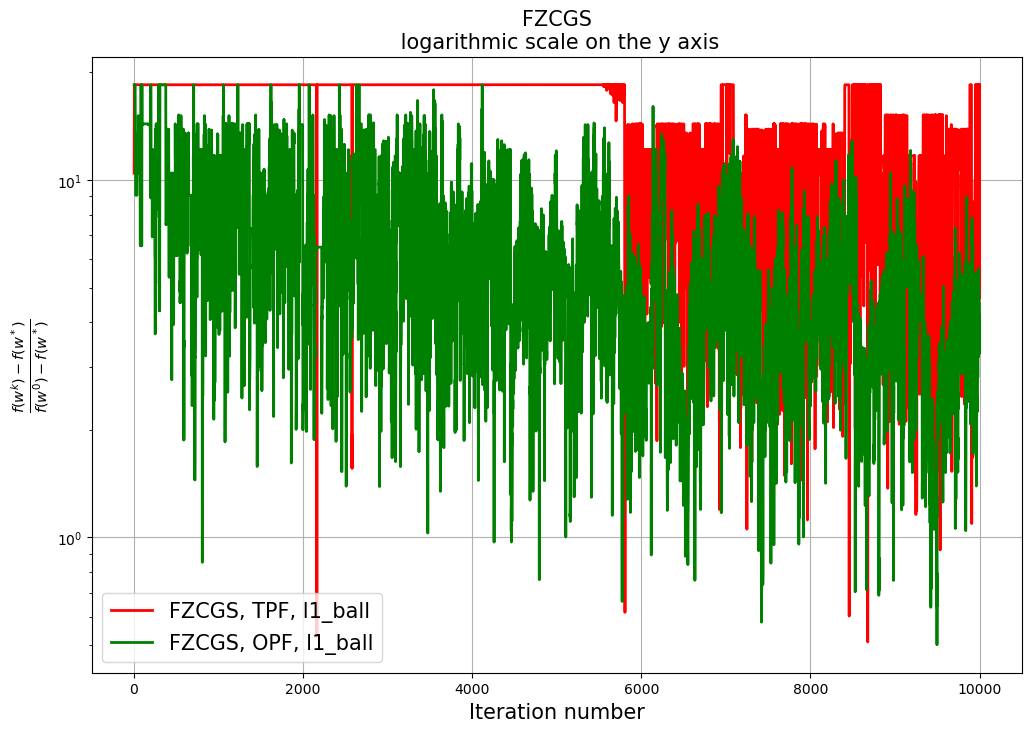

In [131]:
title = "FZCGS"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fzcgs, errors_fzcgs, y_label=y_label,
                         labels=labels_fzcgs, title=title, markers=[None]*100)

# Different grdient methods 

## MBFW TPF

In [238]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['norm'] = 1
args['prob'] = 1e-1

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_mbfw = []
errors_mbfw = []
labels_mbfw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_tpf_lame_v1],
                          ['TPF jaguar', 'TPF lame']):
        args['set'] = Q
        args['batch_size'] = 1
        if name == 'TPF jaguar':
            args['jaguar'] = True
        else:
            args['jaguar'] = False
        optimizer = optimizers.MBFWOptimizer(f, grad, x_0 = w_0, 
                                             step = fw_step, args = args)

        label = f'MBFW, {name}, {Q}'

        iterations, errors, _, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_mbfw.append(iterations)
        errors_mbfw.append(errors)
        labels_mbfw.append(label)

100%|██████████| 10000/10000 [00:00<00:00, 14544.50it/s]


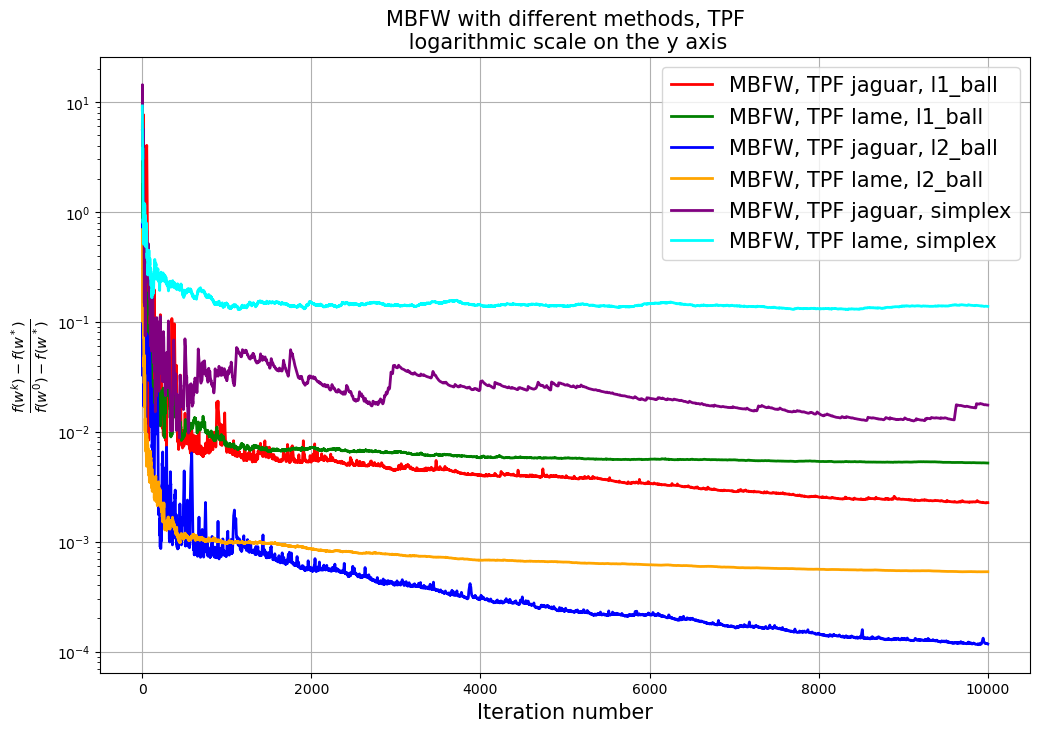

In [239]:
title = "MBFW with different methods, TPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_mbfw, errors_mbfw, y_label=y_label,
                         labels=labels_mbfw, title=title, markers=[None]*100)

## FW TPF

In [236]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['norm'] = 1
args['prob'] =1e-1

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_fw = []
errors_fw = []
labels_fw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_tpf_lame_v1],
                           ['TPF jaguar', 'TPF lame']):
        args['set'] = Q
        args['batch_size'] = 1
        if name == 'TPF jaguar':
            args['jaguar'] = True
        else:
            args['jaguar'] = False
        optimizer = optimizers.FWOptimizer(f, grad, x_0 = w_0, 
                                           step = fw_step, args = args)

        label = f'FW, {name}, {Q}'

        iterations, errors, _, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_fw.append(iterations)
        errors_fw.append(errors)
        labels_fw.append(label)

100%|██████████| 10000/10000 [00:00<00:00, 23279.15it/s]


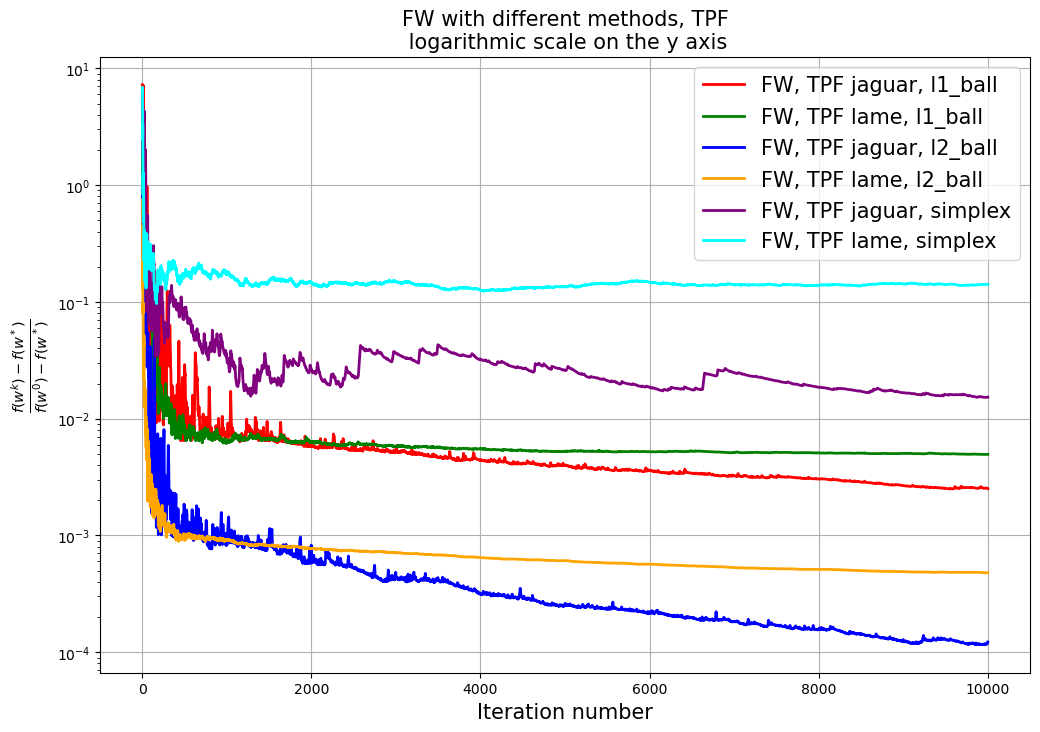

In [237]:
title = "FW with different methods, TPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fw, errors_fw, y_label=y_label,
                         labels=labels_fw, title=title, markers=[None]*100)

## Projection TPF

In [240]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 3
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = True
args['norm'] = 1
args['c'] = 50

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_proj = []
errors_proj = []
labels_proj = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_tpf_lame_v1],
                          ['TPF jaguar', 'TPF lame']):
        args['set'] = Q
        if name == 'TPF jaguar':
            args['jaguar'] = True
        else:
            args['jaguar'] = False
        args['batch_size'] = 1
        optimizer = optimizers.GDOptimizer(f, grad, x_0 = w_0, 
                                           step = const_gamma, args = args)

        label = f'Projection, {name}, {Q}'

        iterations, errors, _, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_proj.append(iterations)
        errors_proj.append(errors)
        labels_proj.append(label)

100%|██████████| 1000/1000 [00:00<00:00, 16987.11it/s]


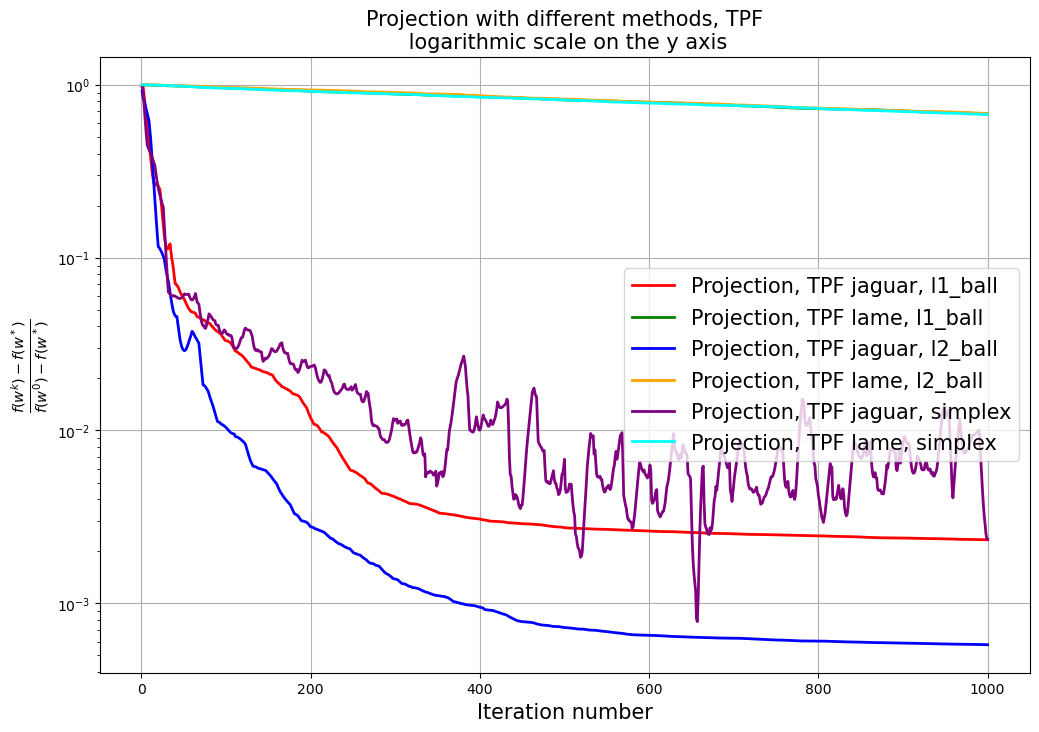

In [241]:
title = "Projection with different methods, TPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_proj, errors_proj, y_label=y_label,
                         labels=labels_proj, title=title, markers=[None]*100)

## FZCGS TPF

In [10]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['gamma'] = lambda k: 1e-1
args['eta'] = eta
args['c'] = 100.
args['eta_0'] = 1.
args['norm'] = 1.

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_fzcgs = []
errors_fzcgs = []
labels_fzcgs = []

for Q, w_0, R_0, w_sol in zip(['l1_ball'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_tpf_jaguar, 
                           optimizers.get_grad_tpf_lame_v1],
                          ['TPF jaguar', 'TPF lame']):
        args['set'] = Q
        if name == 'TPF jaguar':
            args['c'] = 100.
            args['eta_0'] = 10.
        else:
            args['c'] = 100.
            args['eta_0'] = 20.
            
        optimizer = optimizers.FZCGSOptimizer(f, grad, x_0 = w_0, 
                                              step = const_gamma, args = args)

        label = f'FZCGS, {name}, {Q}'

        iterations, errors, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_fzcgs.append(iterations)
        errors_fzcgs.append(errors)
        labels_fzcgs.append(label)

100%|██████████| 10000/10000 [01:04<00:00, 154.68it/s]


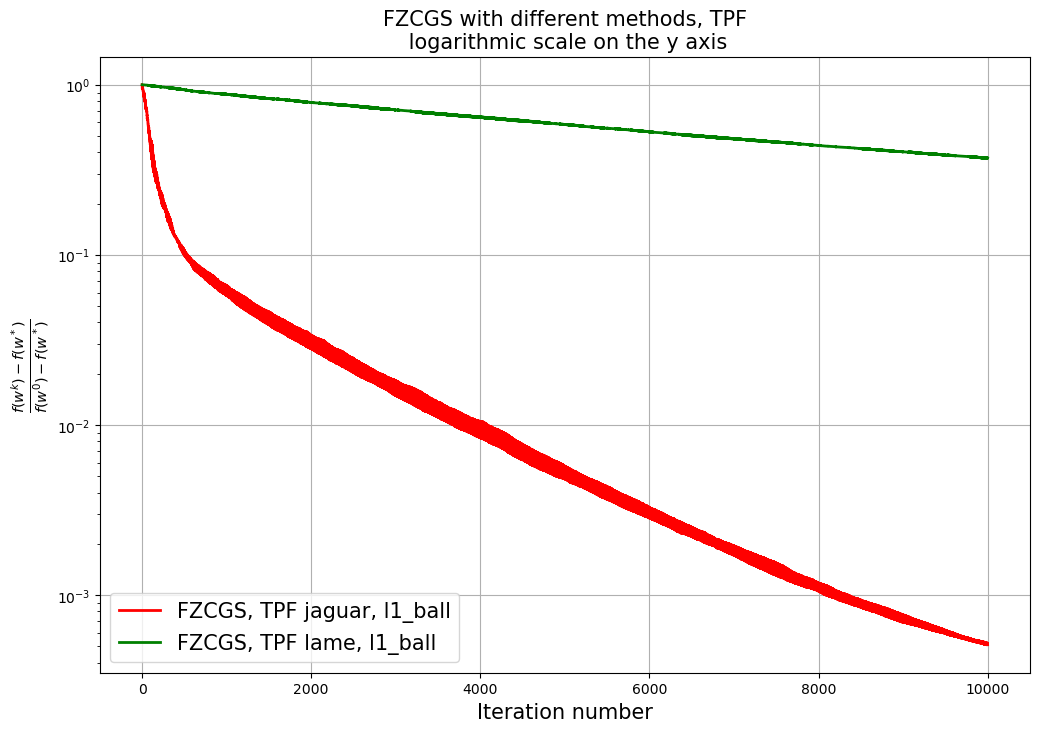

In [12]:
title = "FZCGS with different methods, TPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fzcgs, errors_fzcgs, y_label=y_label,
                         labels=labels_fzcgs, title=title, markers=[None]*100)

## MBFW OPF

In [242]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['norm'] = 1
args['prob'] = 1e-1

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_mbfw = []
errors_mbfw = []
labels_mbfw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_opf_jaguar, 
                           optimizers.get_grad_opf_lame],
                          ['OPF jaguar', 'OPF lame']):
        args['set'] = Q
        args['batch_size'] = 1
        if name == 'OPF jaguar':
            args['jaguar'] = True
        else:
            args['jaguar'] = False
        optimizer = optimizers.MBFWOptimizer(f, grad, x_0 = w_0, 
                                             step = fw_step, args = args)

        label = f'MBFW, {name}, {Q}'

        iterations, errors, _, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_mbfw.append(iterations)
        errors_mbfw.append(errors)
        labels_mbfw.append(label)

100%|██████████| 10000/10000 [00:00<00:00, 18130.49it/s]


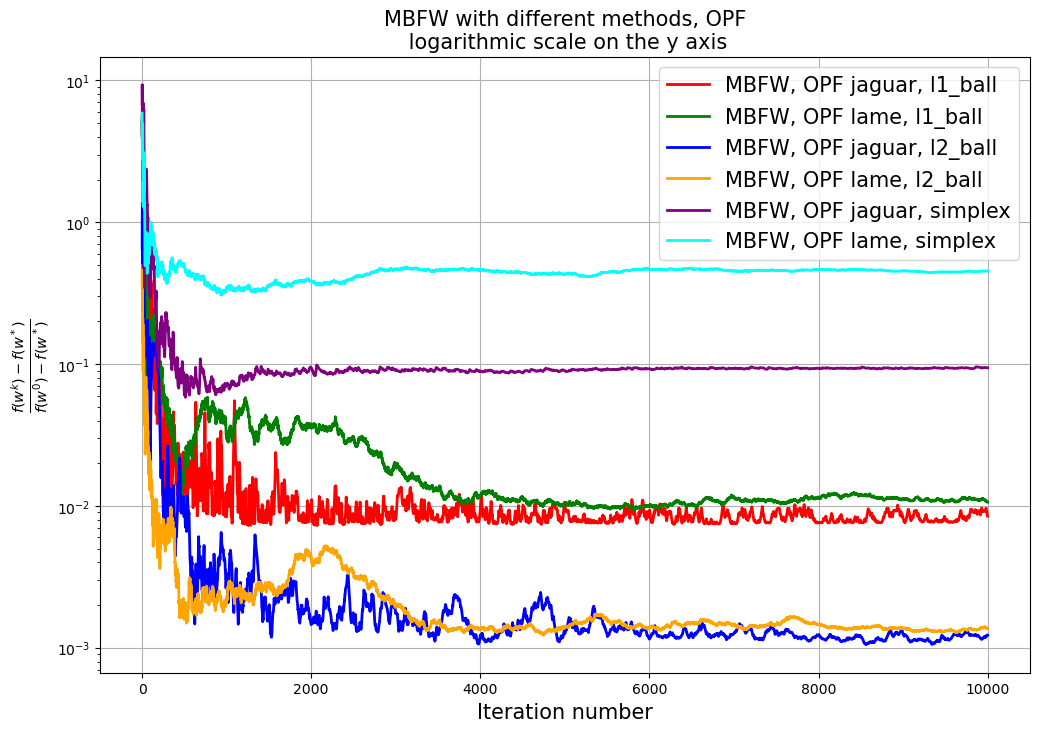

In [243]:
title = "MBFW with different methods, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_mbfw, errors_mbfw, y_label=y_label,
                         labels=labels_mbfw, title=title, markers=[None]*100)

## FW OPF

In [244]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = False
args['norm'] = 1
args['prob'] = 1e-1

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_fw = []
errors_fw = []
labels_fw = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_opf_jaguar, 
                           optimizers.get_grad_opf_lame],
                          ['OPF jaguar', 'OPF lame']):
        args['batch_size'] = 1
        args['set'] = Q
        if name == 'OPF jaguar':
            args['jaguar'] = True
        else:
            args['jaguar'] = False
        optimizer = optimizers.FWOptimizer(f, grad, x_0 = w_0, 
                                           step = fw_step, args = args)

        label = f'FW, {name}, {Q}'

        iterations, errors, _, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_fw.append(iterations)
        errors_fw.append(errors)
        labels_fw.append(label)

100%|██████████| 10000/10000 [00:00<00:00, 29293.21it/s]


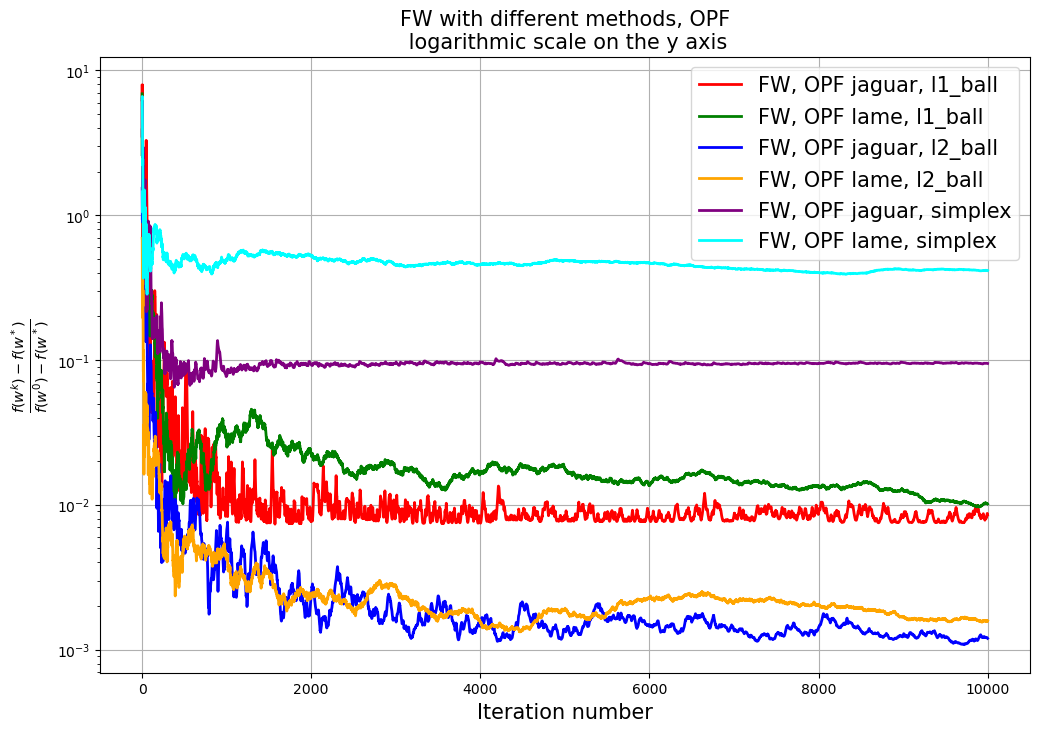

In [245]:
title = "FW with different methods, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_fw, errors_fw, y_label=y_label,
                         labels=labels_fw, title=title, markers=[None]*100)

## Projection OPF

In [248]:
reload(optimizers)
title = ''

args['max_steps'] = 10 ** 4
args['batch_size'] = 1
args['criterium'] = 'f(x_k) - f(x^*)'
args['use_proj'] = True
args['norm'] = 1
args['c'] = 300
args['prob'] = 1e-1

#####
args['grad_curr'] = np.zeros(args['d'])
######

iterations_proj = []
errors_proj = []
labels_proj = []

for Q, w_0, R_0, w_sol in zip(['l1_ball', 'l2_ball', 'simplex'], 
                              [w_0_l1, w_0_l2, w_0_simp],
                              [R_0_l1, R_0_l2, R_0_simp], 
                              [w_true_sol_l1, w_true_sol_l2, w_true_sol_simp]):
    args['x_sol'] = w_sol
    for grad, name in zip([optimizers.get_grad_opf_jaguar, 
                           optimizers.get_grad_opf_lame],
                          ['OPF jaguar', 'OPF lame']):
        args['batch_size'] = 1
        args['set'] = Q
        if name == 'OPF jaguar':
            args['jaguar'] = True
        else:
            args['jaguar'] = False
        optimizer = optimizers.GDOptimizer(f, grad, x_0 = w_0, 
                                           step = const_gamma, args = args)

        label = f'Projection, {name}, {Q}'

        iterations, errors, _, _, _ = calculate(args, optimizer, R_0, label, title)
        iterations_proj.append(iterations)
        errors_proj.append(errors)
        labels_proj.append(label)

100%|██████████| 10000/10000 [00:00<00:00, 20802.70it/s]


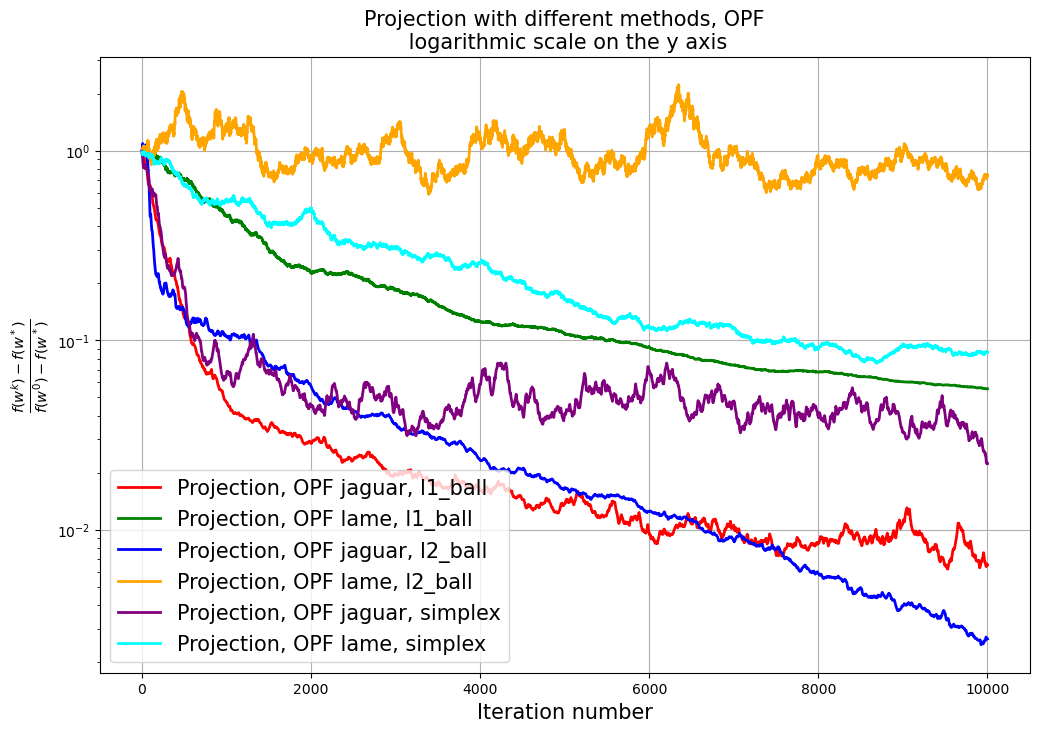

In [249]:
title = "Projection with different methods, OPF"
y_label = r'$\frac{f(w^k) - f(w^*)}{f(w^0) - f(w^*)}$'

optimizers.make_err_plot(iterations_proj, errors_proj, y_label=y_label,
                         labels=labels_proj, title=title, markers=[None]*100)